# Mask R-CNN - Train on Custom Dataset


This notebook shows how to train Mask R-CNN on your own dataset. We use a custom dataset. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import json
import cv2
import skimage
import matplotlib
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

## Configurations

In [2]:
class CustomConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 7

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 30
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     7
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 7
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_data()
* load_mask()
* image_reference()

In [4]:
class CustomDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']+1
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )


    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
TRAIN_DATASET_PATH=os.path.join(ROOT_DIR, "dataset\\train")
TRAIN_JSON_PATH=os.path.join(ROOT_DIR, "dataset\\train\\_annotations.coco.json")
VAL_DATASET_PATH=os.path.join(ROOT_DIR, "dataset\\valid")
VAL_JSON_PATH=os.path.join(ROOT_DIR, "dataset\\valid\\_annotations.coco.json")
# Training dataset
dataset_train = CustomDataset()
dataset_train.load_data(TRAIN_JSON_PATH, TRAIN_DATASET_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_data(VAL_JSON_PATH, VAL_DATASET_PATH)
dataset_val.prepare()

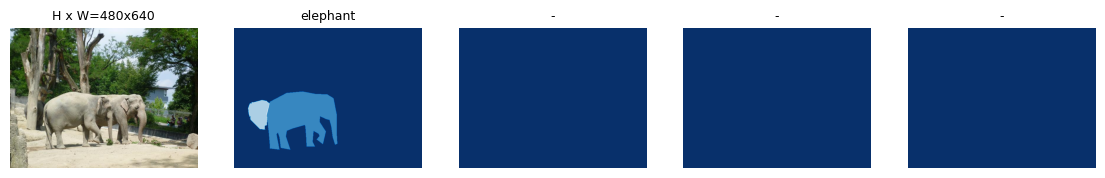

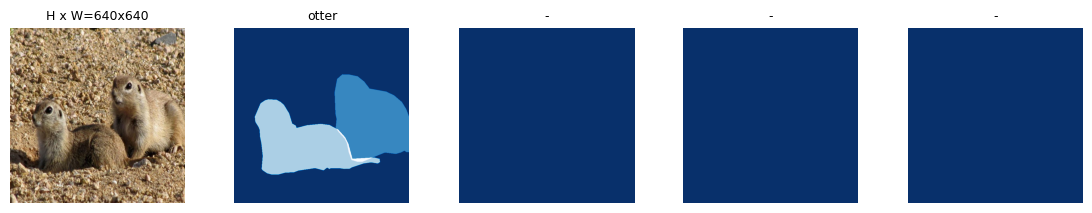

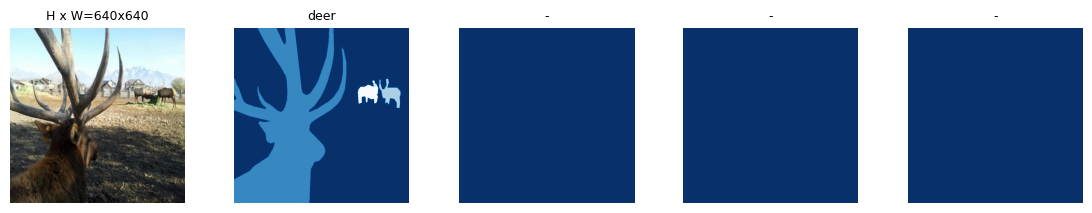

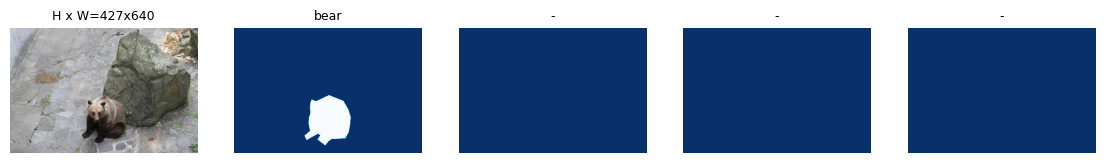

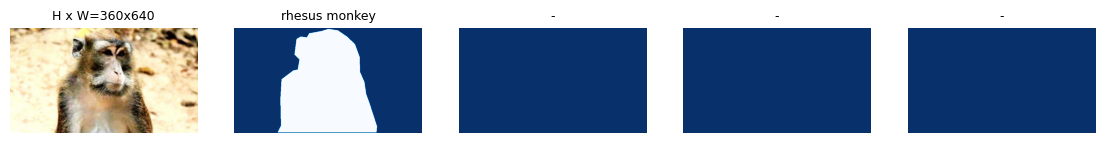

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: d:\Etcs\Cheat Sheets\ML\Applying-Mask-RCNN-in-endangered-animals-detection\logs\custom20230510T1901\mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed

d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/5
100/100 [==============================] - 237s 2s/step - loss: 2.0793 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.5164 - mrcnn_bbox_loss: 0.5148 - mrcnn_mask_loss: 0.4976 - val_loss: 1.1600 - val_rpn_class_loss: 0.0135 - val_rpn_bbox_loss: 0.3827 - val_mrcnn_class_loss: 0.2313 - val_mrcnn_bbox_loss: 0.2861 - val_mrcnn_mask_loss: 0.2463
Epoch 2/5
100/100 [==============================] - 207s 2s/step - loss: 1.0626 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3413 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.2188 - val_loss: 1.1566 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.3795 - val_mrcnn_class_loss: 0.3297 - val_mrcnn_bbox_loss: 0.2233 - val_mrcnn_mask_loss: 0.2142
Epoch 3/5
100/100 [==============================] - 200s 2s/step - loss: 0.9206 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.1993 - val_loss: 1.0440 - val_rpn_class_lo

In [10]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=15, 
            layers='heads')


Starting at epoch 5. LR=0.0001

Checkpoint Path: d:\Etcs\Cheat Sheets\ML\Applying-Mask-RCNN-in-endangered-animals-detection\logs\custom20230510T1901\mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribute

d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 6/15
100/100 [==============================] - 210s 2s/step - loss: 0.6222 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1708 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1832 - val_loss: 0.8800 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.3034 - val_mrcnn_class_loss: 0.2061 - val_mrcnn_bbox_loss: 0.1552 - val_mrcnn_mask_loss: 0.2081
Epoch 7/15
100/100 [==============================] - 200s 2s/step - loss: 0.5987 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1826 - val_loss: 0.8880 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.3051 - val_mrcnn_class_loss: 0.2110 - val_mrcnn_bbox_loss: 0.1571 - val_mrcnn_mask_loss: 0.2076
Epoch 8/15
100/100 [==============================] - 199s 2s/step - loss: 0.5892 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1811 - val_loss: 0.8369 - val_rpn_class_l

In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 15. LR=0.0001

Checkpoint Path: d:\Etcs\Cheat Sheets\ML\Applying-Mask-RCNN-in-endangered-animals-detection\logs\custom20230510T1901\mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a         

d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\Etcs\Cheat Sheets\ML\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Detection

In [12]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model.load_weights(model.find_last(), by_name=True)

# Load trained weights
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 15


original_image           shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (20,)                 min:    0.00000  max:  640.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   41.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


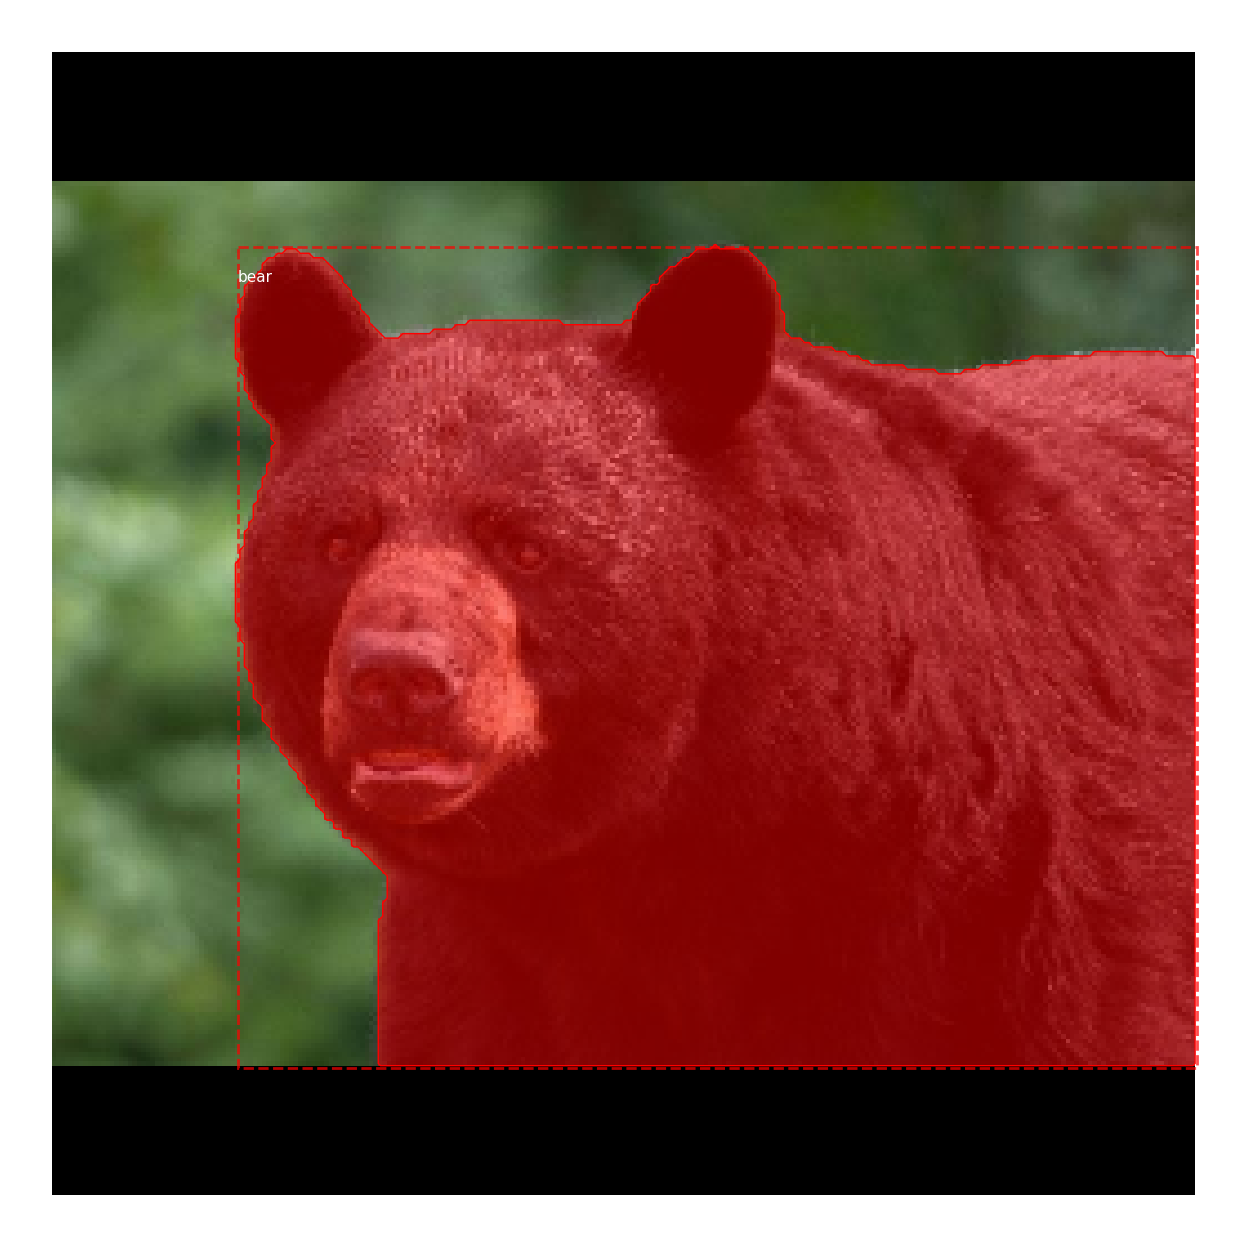

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names)

In [14]:
class_names = ["BG", "bear", "deer","elephant", "otter", "rhesus monkey", "tiger", "turtle"]
CLASS_DICT = {1: 'bear', 2: 'deer', 3: 'elephant', 4: 'otter', 5: 'rhesus monkey', 6: 'tiger', 7: 'turtle'}

## Evaluation

how to calculate AP? on train + val

on mAP/AP:
![Alt text](https://www.researchgate.net/publication/352703047/figure/fig6/AS%3A1038139955101701%401624523261435/Conceptual-explanation-of-average-precision-AP-calculated-using-reference-and-predicted.png)

Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.


1. Finds matches between prediction and ground truth instances
    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
2. Compute precision and recall at each prediction box step
3. Pad with start and end values to simplify the math
4. Ensure precision values decrease but don't increase. This way, the precision value at each recall threshold is the maximum it can be
for all following recall thresholds, as specified by the VOC paper.
5. Compute mean AP over recall range

In [15]:
def dice_coef(y_true, y_pred):
    intersec = y_true*y_pred
    union = y_true+y_pred
    if intersec.sum() == 0:
        dice_coef = 0
    else:
        dice_coef = round(intersec.sum()*2/union.sum(), 2)
    return dice_coef

def coeff_per_image(image_id, pred, gt_mask, gt_class_id):
    
    coeff_dict = {}
    
    for clsid in list(CLASS_DICT.keys()):         
        coeff_dict[clsid] = []
        gt_index = np.where(gt_class_id == clsid)
        
        # if there is no groundtruth or no predicted mask, the coefficient is equal to zero
        if gt_index[0].size ==0 or len(pred['masks']) == 0:
            coeff_dict[clsid].append(0)
        else:
            # get the union of all groundtruth masks belong to clsid
            gt_mask_per_class = gt_mask[:,:,gt_index[0]] # get groundtruth mask

            _gt_sum = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

            for gt_num in range(gt_mask_per_class.shape[2]): # as there may be over one mask per class
                _gt =  gt_mask_per_class[:,:,gt_num]
                _gt_sum = _gt_sum + _gt

            _gt_union = (_gt_sum>0).astype(int)

            # get the union of all predicted masks belong to clsid
            pred_index = np.where(pred['class_ids'] == clsid)
            pred_mask_per_class = pred['masks'][:,:,pred_index[0]]

            _mask_sum = np.zeros((pred['masks'].shape[0],pred['masks'].shape[1]))

            for num in range(pred_mask_per_class.shape[2]):
                _mask = pred_mask_per_class[:,:,num]
                _mask_sum = _mask_sum + _mask

            _mask_union = (_mask_sum>0).astype(int)
            
            coeff_dict[clsid].append(dice_coef(_mask_union, _gt_union))

    for clsid in list(coeff_dict.keys()):    
        coeff_dict[clsid] = np.mean(coeff_dict[clsid])
            
    return [y for x,y in coeff_dict.items() if y!=0]


In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on training images. Increase for better accuracy.

image_ids = dataset_train.image_ids
APs = []

DICEs = []
F1_scores = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                                image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precision, recall, overlap =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

    DICE = coeff_per_image(image_id, r, gt_mask, gt_class_id)
    if not DICE:
        DICEs.append(0)
    else:
        DICEs.append(DICE[0])

    F1_scores.append((2* (np.mean(precision) * np.mean(recall)))/(np.mean(precision) + np.mean(recall)))

print("mAP: ", np.mean(APs))
print("mF1: ", np.mean(F1_scores))
print("mDICE: ", np.mean(DICEs))

mAP:  0.9003380712129327
mF1:  0.6270800982142937
mDICE:  0.8714142857142857


In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on validation images. Increase for better accuracy.

image_ids = dataset_val.image_ids
APs = []
DICEs = []
F1_scores = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                                image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precision, recall, overlap =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
    DICE = coeff_per_image(image_id, r, gt_mask, gt_class_id)
    if not DICE:
        DICEs.append(0)
    else:
        DICEs.append(DICE[0])

    F1_scores.append((2* (np.mean(precision) * np.mean(recall)))/(np.mean(precision) + np.mean(recall)))
    
print("mAP: ", np.mean(APs))
print("mF1: ", np.mean(F1_scores))
print("mDICE: ", np.mean(DICEs))

mAP:  0.8130772010911078
mF1:  0.5663993124722673
mDICE:  0.7783809523809524


In [32]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on test images. Increase for better accuracy.

TEST_DATASET_PATH=os.path.join(ROOT_DIR, "dataset\\test")
TEST_JSON_PATH=os.path.join(ROOT_DIR, "dataset\\test\\_annotations.coco.json")

# Test dataset
dataset_test = CustomDataset()
dataset_test.load_data(TEST_JSON_PATH, TEST_DATASET_PATH)
dataset_test.prepare()

image_ids = dataset_test.image_ids
APs = []
dice_dic = {}
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                                image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7741071428571429
